# MA691 Advanced Statistical Algorithms
# Term Paper

## Suhas.N (140123038)

# Table of contents
1. [Introduction](#introduction)
2. [Implementation](#implementation)
    1. [Collaborative Filtering](#filtering)
    2. [Feature Extraction using Autoencoder](#autoencoder)
3. [Results](#results)



## Introduction <a name="introduction"></a>

We often use ICA or PCA to extract features from the high-dimensional data. The autoencoder is another interesting algorithm to achieve the same purpose in the context of Deep Learning.

with the purpose of learning a function to approximate the input data itself such that F(X) = X, an autoencoder consists of two parts, namely encoder and decoder. While the encoder aims to compress the original input data into a low-dimensional representation, the decoder tries to reconstruct the original input data based on the low-dimension representation generated by the encoder.

## Implementation <a name="implementation"></a>

We first use collaborative filtering - implicit characteristics based on similarity of users’ preferences to those of other users to fill the ratings matrix (users x movies). Then this is inputed into the autoencoder which encodes and decodes the ratings, the layers in middle reduce the features to lower dimension.

To get missing rating of user a on movie p :

1) Consider all neighbours that have rated the movie. 

2) Calculate the similarity between the users using Pearson's coefficient

<img src="https://latex.codecogs.com/svg.latex?\Large&space;PCC=corr(a,b)=\frac{cov(a,b)}{sqrt(var_a)sqrt(var_b)}" />
    
3) Missing rating (a,p) = <img src="https://latex.codecogs.com/svg.latex?\Large&space;=r_{a,avg}+\frac{\sum_{neighbours(n)}{sim(a,b)*(r_{b,p}-r_{b,avg})}}{\sum_{neighbours(n)}{sim(a,b)}}" />

### 1. Collaborative Filtering  <a name="filtering"></a>

In [43]:
import pandas as pd

cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
df = pd.read_csv('ml-100k/u.data', sep='\t', names=cols)

In [44]:
df.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [45]:
df = df.drop('unix_timestamp', 1)
df.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [46]:
input_df = pd.DataFrame(index=range(1,max(df['user_id'])+1), columns=range(1,max(df['movie_id'])+1))   

In [47]:
for index,row in df.iterrows():
    input_df[row['movie_id']][row['user_id']]=row['rating']

In [48]:
input_df.shape

(943, 1682)

#### Truncate and use only first 64 features to reduce running time

In [49]:
input_df=input_df.truncate(after=64,axis=1)
for column in input_df:
    if input_df[column].count()<2:
        print(column)

In [50]:
input_df.shape

(943, 64)

In [51]:
input_df=input_df.dropna(axis=0, how='all')

In [52]:
for column in input_df:
    if input_df[column].count()<2:
        print(column)

In [53]:
input_df.shape

(797, 64)

#### Generate Similarity matrix

In [54]:
import numpy as np
import math

In [56]:
mean_col = input_df.mean(axis=1)

In [57]:
def user_similarity(a,b):
    if(not a in input_df.index or not b in input_df.index):
        return np.nan
    cov=0.0
    var_a=0.0
    var_b=0.0
    for column in input_df:
        avg_rating_a = mean_col[a]
        avg_rating_b = mean_col[b]
        j_rating_a = input_df[column][a]
        j_rating_b = input_df[column][b]
        
        if (not np.isnan(j_rating_a) and not np.isnan(j_rating_b)):
            cov = cov + (j_rating_a-avg_rating_a)*(j_rating_b-avg_rating_b)
            var_a = var_a + (j_rating_a-avg_rating_a)*(j_rating_a-avg_rating_a)
            var_b = var_b + (j_rating_b-avg_rating_b)*(j_rating_b-avg_rating_b)
    if(var_a==0 or var_b==0):
        return 0
    return (cov/(math.sqrt(var_a*var_b)))

In [13]:
sim = np.zeros(shape=(max(df['user_id']),max(df['user_id'])))
num_of_users = max(df['user_id'])
it=0

for i in range(num_of_users):
    for j in range(i+1):
        sim[i][j] = user_similarity(i+1, j+1)
        sim[j][i] = sim[i][j]

In [59]:
sim

array([[1.        , 0.44046501, 0.        , ..., 0.21411269, 0.        ,
        0.22533549],
       [0.44046501, 1.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.21411269, 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.22533549, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [60]:
def round_off_rating(val):
    new_val=int(val)
    frac=val-int(val)
    if(frac>=0.75):
        new_val=new_val+1
    elif(frac>=0.25):
        new_val=new_val+0.5
    return max(min(new_val,5.0),1)
    
def predict_column_rating(column_no):
    temp=input_df[input_df[column_no].notnull()][column_no]
    for index, null_rating in input_df[column_no].iteritems():
        num_sum=0
        den_sum=0
        if(np.isnan(null_rating)):
            for i, rating in temp.iteritems():
                num_sum=num_sum+sim[index-1][i-1]*(rating-mean_col[i])
                den_sum=den_sum+sim[index-1][i-1]
            if(den_sum==0):
                input_df[column_no][index] = round_off_rating(mean_col[index])
            else:
                input_df[column_no][index] = round_off_rating(mean_col[index]+num_sum/den_sum)

In [61]:
for column_no in input_df:
    predict_column_rating(column_no)

In [62]:
input_df.head()

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
1,5,3,4,3,3,5,4,1,5,3,...,5,4,5,4,5,5,4,3,2,5
2,4,3.5,3,3.5,3.5,3.5,3.5,4,3.5,2,...,3.5,4,4,3.5,3,3.5,3,3,3,4.5
4,4.5,4,3.5,4.5,4,4,4.5,5,4,4,...,4.5,4.5,5,4.5,5,4.5,4.5,4,4,5
5,4,3,3,3,3.5,5,3.5,3.5,3,2.5,...,3.5,3.5,3,3.5,3.5,2.5,4,4,1,4
6,4,2.5,3,3.5,3,3.5,2,4,4,4,...,3.5,4,4,3.5,5,4,4,3,2,4


In [63]:
input_df.to_csv("filtered_input.csv", index_label=False)

### Now the input is finally ready, all the missing values have been filled as shown above.

### 2. Dimensionality Reduction using Autoencoders <a name="autoencoder"></a>

In [64]:
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


The following architecture is used for the autoencoder, the input ratings are of dimension 64 and then the next layer reduces it to 16 and the bottleneck layer reduce it further down to 5. Then we decode back to 16 and then the output layer gives dimesion 64 output.

<img src="files/autoencoder_img.jpg">

In [65]:
encoding_dim1 = 16
encoding_dim2 = 5
input_rating = Input(shape=(64,))
encoded = Dense(16, activation='relu')(input_rating) #64->16
encoded = Dense(5, activation='relu')(encoded)       #16->05
decoded = Dense(16, activation='relu')(encoded)      #05->16
decoded = Dense(64, activation='sigmoid')(decoded)   #16->64
autoencoder = Model(input_rating, decoded)

In [66]:
encoder1 = Model(input_rating, autoencoder.layers[1](input_rating))
input_encoding = Input(shape=(encoding_dim1,))
encoder2 = Model(input_encoding, autoencoder.layers[2](input_encoding))
encoded_input1 = Input(shape=(encoding_dim2,))
encoded_input2 = Input(shape=(encoding_dim1,))
decoder_layer1 = autoencoder.layers[-2]
decoder_layer2 = autoencoder.layers[-1]
decoder1 = Model(encoded_input1, decoder_layer1(encoded_input1))
decoder2 = Model(encoded_input2, decoder_layer2(encoded_input2))

In [67]:
autoencoder.compile(optimizer='adam', loss='mse')

In [68]:
input_df=input_df/5
input_df.head()

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
1,1,0.6,0.8,0.6,0.6,1,0.8,0.2,1,0.6,...,1,0.8,1,0.8,1,1,0.8,0.6,0.4,1
2,0.8,0.7,0.6,0.7,0.7,0.7,0.7,0.8,0.7,0.4,...,0.7,0.8,0.8,0.7,0.6,0.7,0.6,0.6,0.6,0.9
4,0.9,0.8,0.7,0.9,0.8,0.8,0.9,1,0.8,0.8,...,0.9,0.9,1,0.9,1,0.9,0.9,0.8,0.8,1
5,0.8,0.6,0.6,0.6,0.7,1,0.7,0.7,0.6,0.5,...,0.7,0.7,0.6,0.7,0.7,0.5,0.8,0.8,0.2,0.8
6,0.8,0.5,0.6,0.7,0.6,0.7,0.4,0.8,0.8,0.8,...,0.7,0.8,0.8,0.7,1,0.8,0.8,0.6,0.4,0.8


In [69]:
x_train=input_df.sample(frac=0.8,random_state=200)
x_test=input_df.drop(x_train.index)

In [70]:
x_train.shape

(638, 64)

In [71]:
autoencoder.fit(x_train,x_train,epochs=100, batch_size=100, shuffle=True, validation_data=(x_test,x_test))

Train on 638 samples, validate on 159 samples
Epoch 1/100
638/638 [==============================] - 0s 354us/step - loss: 0.0907 - val_loss: 0.0971
Epoch 2/100
638/638 [==============================] - 0s 53us/step - loss: 0.0836 - val_loss: 0.0933
Epoch 3/100
638/638 [==============================] - 0s 42us/step - loss: 0.0812 - val_loss: 0.0918
Epoch 4/100
638/638 [==============================] - 0s 48us/step - loss: 0.0797 - val_loss: 0.0894
Epoch 5/100
638/638 [==============================] - 0s 47us/step - loss: 0.0770 - val_loss: 0.0855
Epoch 6/100
638/638 [==============================] - 0s 50us/step - loss: 0.0734 - val_loss: 0.0805
Epoch 7/100
638/638 [==============================] - 0s 54us/step - loss: 0.0691 - val_loss: 0.0746
Epoch 8/100
638/638 [==============================] - 0s 50us/step - loss: 0.0642 - val_loss: 0.0679
Epoch 9/100
638/638 [==============================] - 0s 53us/step - loss: 0.0588 - val_loss: 0.0611
Epoch 10/100
638/638 [=============

638/638 [==============================] - 0s 39us/step - loss: 0.0252 - val_loss: 0.0253
Epoch 81/100
638/638 [==============================] - 0s 45us/step - loss: 0.0252 - val_loss: 0.0252
Epoch 82/100
638/638 [==============================] - 0s 35us/step - loss: 0.0251 - val_loss: 0.0251
Epoch 83/100
638/638 [==============================] - 0s 38us/step - loss: 0.0250 - val_loss: 0.0252
Epoch 84/100
638/638 [==============================] - 0s 37us/step - loss: 0.0249 - val_loss: 0.0249
Epoch 85/100
638/638 [==============================] - 0s 45us/step - loss: 0.0249 - val_loss: 0.0250
Epoch 86/100
638/638 [==============================] - 0s 48us/step - loss: 0.0248 - val_loss: 0.0249
Epoch 87/100
638/638 [==============================] - 0s 41us/step - loss: 0.0247 - val_loss: 0.0248
Epoch 88/100
638/638 [==============================] - 0s 41us/step - loss: 0.0247 - val_loss: 0.0248
Epoch 89/100
638/638 [==============================] - 0s 39us/step - loss: 0.0246 - 

In [72]:
encoded_output1 = encoder1.predict(input_df)
encoded_output2 = encoder2.predict(encoded_output1)
decoded_output1 = decoder1.predict(encoded_output2)
decoded_output2 = decoder2.predict(decoded_output1)

In [73]:
encoded_output2

array([[0.       , 0.       , 0.       , 0.       , 2.5467837],
       [0.       , 0.       , 0.       , 0.       , 3.0671315],
       [0.       , 0.       , 0.       , 0.       , 4.9697094],
       ...,
       [0.       , 0.       , 0.       , 0.       , 5.081753 ],
       [0.       , 0.       , 0.       , 0.       , 8.523407 ],
       [0.       , 0.       , 0.       , 0.       , 4.541972 ]],
      dtype=float32)

In [74]:
decoded_output2

array([[0.6766077 , 0.585756  , 0.54231805, ..., 0.58392555, 0.5763431 ,
        0.76945156],
       [0.7094686 , 0.62192684, 0.5763254 , ..., 0.6131011 , 0.60951674,
        0.80978876],
       [0.81122655, 0.7409461 , 0.69261825, ..., 0.71186453, 0.7207205 ,
        0.9120297 ],
       ...,
       [0.816271  , 0.7471496 , 0.6989093 , ..., 0.7171989 , 0.7266409 ,
        0.916145  ],
       [0.92509604, 0.88934785, 0.85258865, ..., 0.84991616, 0.868425  ,
        0.9820333 ],
       [0.7909949 , 0.71637094, 0.6679497 , ..., 0.6909611 , 0.6974129 ,
        0.8945963 ]], dtype=float32)

In [75]:
ans=decoded_output2*5
for (x,y), value in np.ndenumerate(ans):
    ans[x][y] = round_off_rating(ans[x][y])

In [76]:
ans

array([[3.5, 3. , 2.5, ..., 3. , 3. , 4. ],
       [3.5, 3. , 3. , ..., 3. , 3. , 4. ],
       [4. , 3.5, 3.5, ..., 3.5, 3.5, 4.5],
       ...,
       [4. , 3.5, 3.5, ..., 3.5, 3.5, 4.5],
       [4.5, 4.5, 4.5, ..., 4. , 4.5, 5. ],
       [4. , 3.5, 3.5, ..., 3.5, 3.5, 4.5]], dtype=float32)

In [77]:
ans_df=pd.DataFrame(ans)

In [78]:
df=input_df.copy()
df=df*5

In [79]:
ans_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,3.5,3.0,2.5,3.0,3.0,3.0,3.0,3.5,3.5,3.0,...,3.0,3.5,3.5,3.5,3.5,3.0,3.0,3.0,3.0,4.0
1,3.5,3.0,3.0,3.5,3.0,3.0,3.5,3.5,3.5,3.5,...,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.0,3.0,4.0
2,4.0,3.5,3.5,4.0,3.5,3.5,4.0,4.5,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.5,3.5,4.5
3,4.0,3.5,3.5,4.0,3.5,3.5,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.5,3.5,4.5
4,3.5,3.0,3.0,3.5,3.0,3.5,3.5,4.0,3.5,3.5,...,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.0,3.0,4.0


In [80]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
1,5,3,4,3,3,5,4,1,5,3,...,5,4,5,4,5,5,4,3,2,5
2,4,3.5,3,3.5,3.5,3.5,3.5,4,3.5,2,...,3.5,4,4,3.5,3,3.5,3,3,3,4.5
4,4.5,4,3.5,4.5,4,4,4.5,5,4,4,...,4.5,4.5,5,4.5,5,4.5,4.5,4,4,5
5,4,3,3,3,3.5,5,3.5,3.5,3,2.5,...,3.5,3.5,3,3.5,3.5,2.5,4,4,1,4
6,4,2.5,3,3.5,3,3.5,2,4,4,4,...,3.5,4,4,3.5,5,4,4,3,2,4


## Results <a name="results"></a>

In [84]:
import matplotlib.pyplot as plt

### Plot of initial filtered and the autoencoder(AE) predictions for user-1 ratings

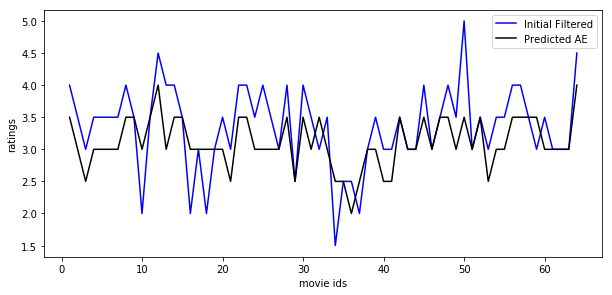

In [99]:
plt.figure(figsize=(10,10))
plt.subplot(211)
line1,=plt.plot(range(1,65), df.iloc[1], 'b')
line2,=plt.plot(range(1,65), ans_df.iloc[0], 'k')
plt.ylabel('ratings')
plt.xlabel('movie ids')
plt.legend([line1, line2], ['Initial Filtered', 'Predicted AE'])


We see here that the autoencoder captures the ratings fairely neatly and captures the nature of the ratings.

### Plot of movie-1 ratings

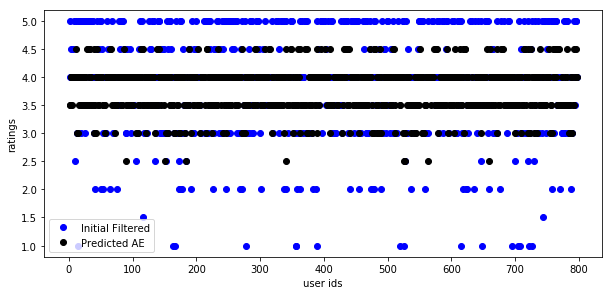

In [101]:
plt.figure(figsize=(10,10))
plt.subplot(212)
line1,=plt.plot(range(1,798), df[1].tolist(), 'bo')
line2,=plt.plot(range(1,798), ans_df[0].tolist(), 'ko')
plt.ylabel('ratings')
plt.xlabel('user ids')
plt.legend([line1, line2], ['Initial Filtered', 'Predicted AE'])

Again, this observations all indicates that the autoencoder captures the ratings for movie1 upto a good accuracy.

Therefore, we were able to reduce the dimension of the features from 64 to 5 and still recover the ratings of the users using autoencoders.